In [18]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the NetCDF file
ds = xr.open_dataset('/data/GLOBARGO/data/15228690/fseq_OCIM2_48L.nc', chunks={'time': 1})

# Print structure to understand the file better
ds = ds.assign_coords(time=np.arange(0, 1001))  # 0–1000 years, total 1001 steps
ds


<xarray.Dataset>
Dimensions:        (time: 1001, ocean grid point: 405386, depth: 48,
                    longitude: 180, latitude: 91)
Coordinates:
  * time           (time) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Dimensions without coordinates: ocean grid point, depth, longitude, latitude
Data variables:
    fseq           (time, ocean grid point) float64 dask.array<chunksize=(1, 405386), meta=np.ndarray>
    MASK           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LAT            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LON            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    DEPTH          (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    VOL            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    AREA           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    mean_seq_time  (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>

In [16]:

# Get all depth values (for levels 0-23 if using 24 levels for 0-1000m)
depth_values = ds['DEPTH'].isel(depth=slice(0, 24)).compute()  # First 24 levels
# Print unique depth values
print("Actual depth values (m):")
print(depth_values.values.flatten())

# Check if differences between levels are constant
depth_diff = np.diff(np.sort(np.unique(depth_values)))
print("\nDifferences between levels (m):")
print(depth_diff)
# Get exact depth values per level
depth_levels = ds['DEPTH'].isel(depth=slice(0, 24)).values.flatten()

np.unique(depth_levels)

Actual depth values (m):
[  4.93454087   4.93454087   4.93454087 ... 831.56158473 831.56158473
 831.56158473]

Differences between levels (m):
[ 9.94293791 10.23836255 10.82921183 11.71548575 12.89718431 14.37430751
 16.14685535 18.21482784 20.57822496 23.23704672 26.19129312 29.44096417
 32.98605985 36.82658018 40.96252514 45.39389475 50.12068899 55.14290788
 60.4605514  66.07361957 71.98211237 78.18602982 84.68537191]


array([  4.93454087,  14.87747878,  25.11584133,  35.94505315,
        47.6605389 ,  60.55772321,  74.93203072,  91.07888608,
       109.29371391, 129.87193887, 153.10898559, 179.30027871,
       208.74124288, 241.72730273, 278.55388291, 319.51640805,
       364.9103028 , 415.03099179, 470.17389966, 530.63445106,
       596.70807063, 668.69018301, 746.87621283, 831.56158473])

In [17]:
ds

<xarray.Dataset>
Dimensions:        (time: 1001, ocean grid point: 405386, depth: 48,
                    longitude: 180, latitude: 91)
Coordinates:
  * time           (time) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Dimensions without coordinates: ocean grid point, depth, longitude, latitude
Data variables:
    fseq           (time, ocean grid point) float64 dask.array<chunksize=(1, 405386), meta=np.ndarray>
    MASK           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LAT            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LON            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    DEPTH          (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    VOL            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    AREA           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    mean_seq_time  (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>

In [16]:
# Select the closest time to 50 years
ds_50yr = ds.sel(time=50, method='nearest')

# 2. Select 50-year data (convert to NumPy)
ds_50yr = ds.sel(time=50, method='nearest')
fseq_50yr_np = ds_50yr['fseq'].compute().data

In [17]:
mask_np = ds['MASK'].compute().data

# 3. Reconstruct 3D array
fseq_3d_np = np.full_like(mask_np, np.nan, dtype=float)
fseq_3d_np[mask_np == 1] = fseq_50yr_np

# 4. Create xarray DataArray
fseq_3d = xr.DataArray(
    fseq_3d_np,
    dims=ds['MASK'].dims,
    coords={dim: ds[dim] for dim in ds['MASK'].dims}
)

# 5. Filter depths ≤1000m
depth_mask = (ds['DEPTH'] <= 1000) & (ds['MASK'] == 1)
fseq_shallow = fseq_3d.where(depth_mask.compute())  # Compute the mask if Dask-backed

(array([1.90000e+01, 8.90000e+01, 1.23759e+05, 4.47380e+04, 2.87130e+04,
        2.23770e+04, 1.85530e+04, 1.61370e+04, 2.28000e+02, 1.50000e+01]),
 array([-0.51093393, -0.31749556, -0.12405719,  0.06938118,  0.26281955,
         0.45625792,  0.64969629,  0.84313466,  1.03657303,  1.2300114 ,
         1.42344977]),
 <BarContainer object of 10 artists>)

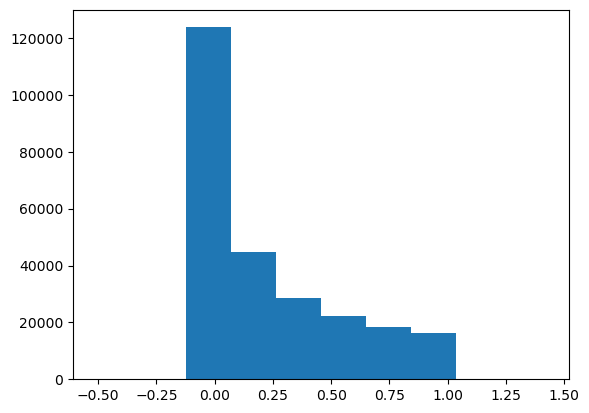

In [23]:
unique_values = np.unique(fseq_shallow.values)
fseq_shallow.plot.hist()

In [28]:
# Ensure fseq_shallow is computed (if Dask-backed)
fseq_valid = fseq_shallow.where((fseq_shallow >= 0) & (fseq_shallow <= 1)).compute()

# Convert to a Pandas DataFrame with coordinates
df = fseq_valid.to_dataframe(name='fseq').reset_index()

df_clean = df.dropna(subset=['fseq'])
df_clean

,depth,longitude,latitude,fseq
9,0,0,9,0.000000
10,0,0,10,0.000000
11,0,0,11,0.000000
12,0,0,12,0.000000
13,0,0,13,0.000000
...,...,...,...,...
409494,24,179,85,0.813195
409495,24,179,86,0.791981
409496,24,179,87,0.786636
409497,24,179,88,0.794703


In [43]:
# Get all depth values (for levels 0-23 if using 24 levels for 0-1000m)
depth_values = ds['DEPTH'].isel(depth=slice(0, 24)).compute()  # First 24 levels
# Print unique depth values
print("Actual depth values (m):")
print(depth_values.values.flatten())

# Check if differences between levels are constant
depth_diff = np.diff(np.sort(np.unique(depth_values)))
print("\nDifferences between levels (m):")
print(depth_diff)
# Get exact depth values per level
depth_levels = ds['DEPTH'].isel(depth=slice(0, 24)).values.flatten()

np.unique(depth_levels)

Actual depth values (m):
[  4.93454087   4.93454087   4.93454087 ... 831.56158473 831.56158473
 831.56158473]

Differences between levels (m):
[ 9.94293791 10.23836255 10.82921183 11.71548575 12.89718431 14.37430751
 16.14685535 18.21482784 20.57822496 23.23704672 26.19129312 29.44096417
 32.98605985 36.82658018 40.96252514 45.39389475 50.12068899 55.14290788
 60.4605514  66.07361957 71.98211237 78.18602982 84.68537191]


array([  4.93454087,  14.87747878,  25.11584133,  35.94505315,
        47.6605389 ,  60.55772321,  74.93203072,  91.07888608,
       109.29371391, 129.87193887, 153.10898559, 179.30027871,
       208.74124288, 241.72730273, 278.55388291, 319.51640805,
       364.9103028 , 415.03099179, 470.17389966, 530.63445106,
       596.70807063, 668.69018301, 746.87621283, 831.56158473])

In [44]:
# Your 24 unique depth values (in meters)
depth_values = np.array([
    4.93454087, 14.87747878, 25.11584133, 35.94505315,
    47.6605389, 60.55772321, 74.93203072, 91.07888608,
    109.29371391, 129.87193887, 153.10898559, 179.30027871,
    208.74124288, 241.72730273, 278.55388291, 319.51640805,
    364.9103028, 415.03099179, 470.17389966, 530.63445106,
    596.70807063, 668.69018301, 746.87621283, 831.56158473
])

# Create a mapping from level index (0-23) to depth
level_to_depth = {i: depth_values[i] for i in range(len(depth_values))}

<Axes: ylabel='Frequency'>

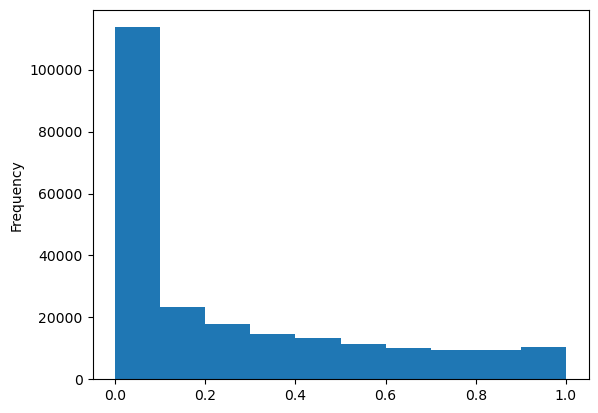

In [51]:
# Map level indices to actual depths
df['depth_meters'] = df['depth'].map(level_to_depth)
df.fseq.plot.hist()

In [53]:
df.to_csv('co2_sequestration_50years.csv', index=False)

In [25]:
ds

<xarray.Dataset>
Dimensions:        (time: 1001, ocean grid point: 405386, depth: 48,
                    longitude: 180, latitude: 91)
Coordinates:
  * time           (time) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Dimensions without coordinates: ocean grid point, depth, longitude, latitude
Data variables:
    fseq           (time, ocean grid point) float64 dask.array<chunksize=(1, 405386), meta=np.ndarray>
    MASK           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LAT            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    LON            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    DEPTH          (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    VOL            (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    AREA           (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>
    mean_seq_time  (depth, longitude, latitude) float64 dask.array<chunksize=(48, 180, 91), meta=np.ndarray>

In [26]:
mean_seq_ds = ds[['mean_seq_time','DEPTH']]


In [28]:
mean_seq_ds = mean_seq_ds.to_dataframe()
mean_seq_ds.to_csv("data/df_meanseq.csv")

In [6]:
ds = xr.open_dataset('data/global_kappa_epsilon_for_Kiera.nc', chunks={})
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 120, z: 7)
Coordinates:
  * lon      (lon) float64 1.5 4.5 7.5 10.5 13.5 ... 349.5 352.5 355.5 358.5
  * lat      (lat) float64 66.0 63.0 60.0 57.0 54.0 ... -57.0 -60.0 -63.0 -66.0
  * z        (z) float64 375.0 625.0 875.0 ... 1.375e+03 1.625e+03 1.875e+03
Data variables:
    K        (lat, lon, z) float64 dask.array<chunksize=(45, 120, 7), meta=np.ndarray>
    e        (lat, lon, z) float64 dask.array<chunksize=(45, 120, 7), meta=np.ndarray>
Attributes:
    info:     K=kappa, e=epsilon, z=depth at the center of the 250m bin avera...

In [13]:
import xarray as xr
import pandas as pd

# ------------------------------------------------------------------
# 1.  Open lazily (nothing loads into RAM yet)
# ------------------------------------------------------------------
ds = xr.open_dataset('data/global_kappa_epsilon_for_Kiera.nc', chunks={})

# ------------------------------------------------------------------
# 2.  Select the K_h variable and depth ≤ 200 m
#     Your z coordinate is “at the centre of 250 m bins”; so pick bins
#     whose centre ≤ 200 m, i.e. z <= 200
# ------------------------------------------------------------------
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 120, z: 7)
Coordinates:
  * lon      (lon) float64 1.5 4.5 7.5 10.5 13.5 ... 349.5 352.5 355.5 358.5
  * lat      (lat) float64 66.0 63.0 60.0 57.0 54.0 ... -57.0 -60.0 -63.0 -66.0
  * z        (z) float64 375.0 625.0 875.0 ... 1.375e+03 1.625e+03 1.875e+03
Data variables:
    K        (lat, lon, z) float64 dask.array<chunksize=(45, 120, 7), meta=np.ndarray>
    e        (lat, lon, z) float64 dask.array<chunksize=(45, 120, 7), meta=np.ndarray>
Attributes:
    info:     K=kappa, e=epsilon, z=depth at the center of the 250m bin avera...

In [15]:
import xarray as xr
import pandas as pd

# ------------------------------------------------------------------
# 1.  Open lazily (nothing loads into RAM yet)
# ------------------------------------------------------------------
ds = xr.open_dataset('data/global_kappa_epsilon_for_Kiera.nc', chunks={})

# ------------------------------------------------------------------
# 2.  Select the K_h variable and depth ≤ 200 m
#     Your z coordinate is “at the centre of 250 m bins”; so pick bins
#     whose centre ≤ 200 m, i.e. z <= 200
# ------------------------------------------------------------------
kh_top1000 = (ds['K']               # dims: (lat, lon, z)
               .sel(z=slice(None, 1125))        # keep shallower bins
               .mean('z', skipna=True))        # reduce to (lat, lon)

# ------------------------------------------------------------------
# 3.  Convert longitudes 0–360 → −180–180  (wrap to match Argo)
# ------------------------------------------------------------------
lon = kh_top1000['lon']
lon_wrapped = xr.where(lon > 180, lon - 360, lon)
kh_top1000 = kh_top1000.assign_coords(lon=lon_wrapped).sortby('lon')

# ------------------------------------------------------------------
# 4.  Flatten to 2‑D table and save
# ------------------------------------------------------------------
(df := kh_top1000
        .stack(point=('lat', 'lon'))     # single index (‘point’)
        .to_dataframe(name='kappa_h')    # columns: lat, lon, kappa_h
        .reset_index(drop=True)          # simple RangeIndex if you like
).to_csv('data/kh_surface_top1000m.csv', index=False)

print("✓  Saved kh_surface_top1000m.csv with", len(df), "rows")


✓  Saved kh_surface_top1000m.csv with 5400 rows


In [23]:
import xarray as xr
import pandas as pd

# 1. open lazily (Dask keeps memory use tiny) ────────────────────────────────
ds = xr.open_dataset(
        "data/ArgoTS_eddydiffusivity_20052015_1deg.nc",  # your file
        chunks={}
     )                                                                   # :contentReference[oaicite:0]{index=0}
# 2. select horizontal diffusivity ('diffusivity') & depth ≤ 200 m ───────────
kh_top200 = (ds['diffusivity']                       # dims: (lat, lon, depth)  :contentReference[oaicite:1]{index=1}
               .sel(depth=slice(None, 200))          # keep only shallow bins
               .mean('depth', skipna=True))          # average over depth

# 3. wrap longitudes 0–360 ° → −180 … 180 ° so they match Argo conventions ───
lon_wrapped = xr.where(kh_top200['lon'] > 180,
                       kh_top200['lon'] - 360,
                       kh_top200['lon'])                             # :contentReference[oaicite:2]{index=2}
kh_top200 = kh_top200.assign_coords(lon=lon_wrapped).sortby('lon')

# 4. flatten to 2‑D tidy table and save to CSV/Parquet ───────────────────────
df = (kh_top200
        .stack(point=('lat', 'lon'))                 # collapses to 1 dim.  :contentReference[oaicite:3]{index=3}
        .to_dataframe(name='kh200')                  # columns: lat, lon, kh200
        .dropna()                                    # purge land cells (mask = NaN)
        .reset_index(drop=True)                      # simple Int64 index
     )

df.to_csv("data/eddy_diffusivity_top200m.csv", index=False)        # human‑readable

print(f"✓  Wrote {len(df):,} rows to eddy_diffusivity_top200m.csv")

✓  Wrote 21,829 rows to eddy_diffusivity_top200m.csv


In [24]:
import xarray as xr
import pandas as pd

# 1. open lazily (Dask keeps memory use tiny) ────────────────────────────────
ds = xr.open_dataset(
        "data/ArgoTS_eddydiffusivity_20052015_1deg.nc",  # your file
        chunks={}
     )                                                                   # :contentReference[oaicite:0]{index=0}
# 2. select horizontal diffusivity ('diffusivity') & depth ≤ 200 m ───────────
kh_top500 = (ds['diffusivity']                       # dims: (lat, lon, depth)  :contentReference[oaicite:1]{index=1}
               .sel(depth=slice(None, 500))          # keep only shallow bins
               .mean('depth', skipna=True))          # average over depth

# 3. wrap longitudes 0–360 ° → −180 … 180 ° so they match Argo conventions ───
lon_wrapped = xr.where(kh_top500['lon'] > 180,
                       kh_top500['lon'] - 360,
                       kh_top500['lon'])                             # :contentReference[oaicite:2]{index=2}
kh_top500 = kh_top500.assign_coords(lon=lon_wrapped).sortby('lon')

# 4. flatten to 2‑D tidy table and save to CSV/Parquet ───────────────────────
df = (kh_top500
        .stack(point=('lat', 'lon'))                 # collapses to 1 dim.  :contentReference[oaicite:3]{index=3}
        .to_dataframe(name='kh200')                  # columns: lat, lon, kh200
        .dropna()                                    # purge land cells (mask = NaN)
        .reset_index(drop=True)                      # simple Int64 index
     )

df.to_csv("data/eddy_diffusivity_top500m.csv", index=False)        # human‑readable

print(f"✓  Wrote {len(df):,} rows to eddy_diffusivity_top500m.csv")



✓  Wrote 22,598 rows to eddy_diffusivity_top500m.csv


In [26]:
import xarray as xr
import pandas as pd

# 1. open lazily (Dask keeps memory use tiny) ────────────────────────────────
ds = xr.open_dataset(
        "data/ArgoTS_eddydiffusivity_20052015_1deg.nc",  # your file
        chunks={}
     )                                                                   # :contentReference[oaicite:0]{index=0}
# 2. select horizontal diffusivity ('diffusivity') & depth ≤ 200 m ───────────
kh_interior = (ds['diffusivity']                       # dims: (lat, lon, depth)  :contentReference[oaicite:1]{index=1}
               .sel(depth=slice(300, 800))          # keep only shallow bins
               .mean('depth', skipna=True))          # average over depth

# 3. wrap longitudes 0–360 ° → −180 … 180 ° so they match Argo conventions ───
lon_wrapped = xr.where(kh_interior['lon'] > 180,
                       kh_interior['lon'] - 360,
                       kh_interior['lon'])                             # :contentReference[oaicite:2]{index=2}
kh_interior = kh_interior.assign_coords(lon=lon_wrapped).sortby('lon')

# 4. flatten to 2‑D tidy table and save to CSV/Parquet ───────────────────────
df = (kh_interior
        .stack(point=('lat', 'lon'))                 # collapses to 1 dim.  :contentReference[oaicite:3]{index=3}
        .to_dataframe(name='kh200')                  # columns: lat, lon, kh200
        .dropna()                                    # purge land cells (mask = NaN)
        .reset_index(drop=True)                      # simple Int64 index
     )

df.to_csv("data/eddy_diffusivity_interior.csv", index=False)        # human‑readable

print(f"✓  Wrote {len(df):,} rows to eddy_diffusivity_interiorm.csv")

✓  Wrote 21,700 rows to eddy_diffusivity_interiorm.csv


In [28]:
surf

<xarray.DataArray 'diffusivity' (lat: 131, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: lat, lon

In [32]:
df = (surf                                     # (lat, lon) DataArray
        .stack(point=('lat', 'lon'))           # make a single index
        .to_dataframe(name='kappa_h')          # lon/lat are columns now
        .dropna()                              # optional
      ) 
df
df.to_csv("data/kappa_surface.csv", index=False)

In [18]:
df3d = (ds3d['diffusivity']
          .stack(point=('lat', 'lon', 'depth'))
          .to_dataframe(name='kappa_h')        # now has lat, lon, depth, kappa_h
          .reset_index(drop=True)              # only if you really want a clean Int64 index
        )

NameError: name 'df' is not defined